# Image Collection

### Data prep

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure

In [4]:
DATASET_PATH = "./data/"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv', 'temp_data.csv']


In [5]:
df = pd.read_csv(DATASET_PATH + "styles.csv", error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row["id"]) + ".jpg", axis=1)
df = df.reset_index(drop=True)  

In [6]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

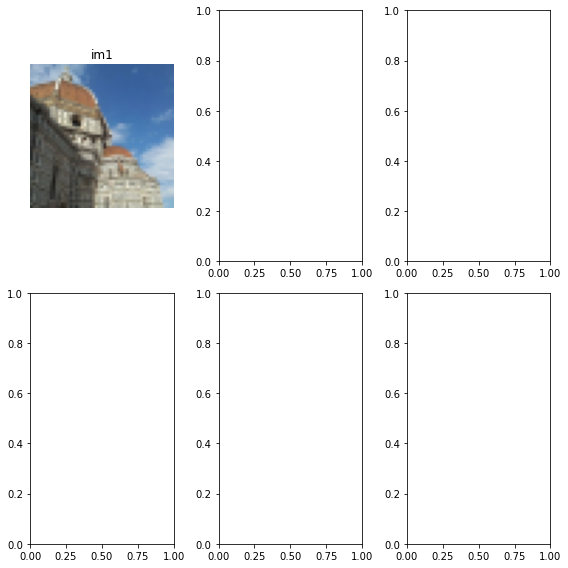

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample().iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [14]:
plt.figure(figsize=(7,20))
df.location.value_counts().sort_values().plot(kind='london')

ValueError: london is not a valid plot kind

<Figure size 504x1440 with 0 Axes>

### Use Pre-Trained Model to Recommendation

In [30]:
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet import ResNet50
import keras.utils as image
from keras.applications.resnet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__

'2.10.1'

In [31]:
# Input Shape
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [32]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [33]:
emb = get_embedding(model, df.iloc[0].image)
emb.shape

1/1 [==============================] - 17s 17s/step


(2048,)

(78, 106, 3)
[ 2.2946668  3.8473396  1.2614756 ... 16.509003   3.7165823  6.7829094]


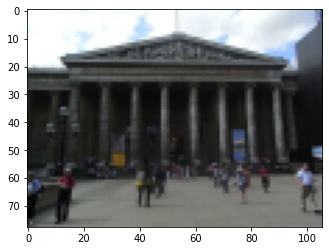

In [34]:
img_array = load_image(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [35]:
df.shape

(10, 6)

In [36]:
%%time
#import swifter

# Parallel apply
df_sample      = df#.sample(10)
map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

1/1 [==============================] - 1s 1s/step
(10, 2048)
Wall time: 18.6 s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2.294667,3.847340,1.261476,2.439571,5.620037,3.301247,0.000000,1.989974,21.533636,7.122469,...,0.000000,1.629816,6.991650,1.661416,5.473810,2.289881,11.095861,16.509003,3.716582,6.782909
1,5.226571,6.602130,0.000000,0.052960,4.903149,2.526455,7.914747,3.392181,2.687384,3.709607,...,0.000000,3.939210,1.759311,9.090741,0.000000,0.000000,0.034091,0.103461,1.016014,2.555355
2,8.106752,2.702454,7.793443,1.747245,11.014935,4.590415,0.000000,0.782135,18.392597,0.000000,...,4.281124,8.712884,0.000000,9.840500,9.802209,8.199417,0.058367,8.883587,0.000000,5.702641
3,0.000000,3.216957,2.556778,0.561639,2.171459,6.616309,2.149569,0.510838,1.514285,4.660577,...,0.000000,1.491215,3.180527,3.625294,2.986604,0.000000,17.373741,5.881586,0.000000,1.952446
4,3.164220,5.583426,1.094318,4.669735,4.796284,10.281895,0.000000,7.979677,17.101057,1.254446,...,0.759755,5.142893,9.408710,6.797791,2.327881,1.580978,7.251422,1.971438,4.553909,0.000000


### Compute Similarity Between Items

In [37]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[0.9999993 , 0.5945163 , 0.56336373, 0.5825622 ],
       [0.5945159 , 0.99999976, 0.49550974, 0.56220406],
       [0.56336373, 0.49550974, 0.9999997 , 0.5059236 ],
       [0.5825617 , 0.5622043 , 0.5059236 , 0.99999875]], dtype=float32)

### Recommender Similar Items

In [39]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(1, df, top_n = 5)

(Int64Index([8, 9, 4, 7, 6], dtype='int64'),
 [0.6835139, 0.66617703, 0.6627973, 0.60827804, 0.597233])

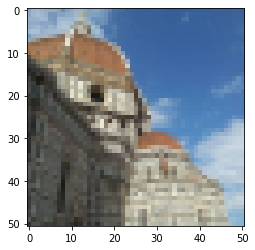

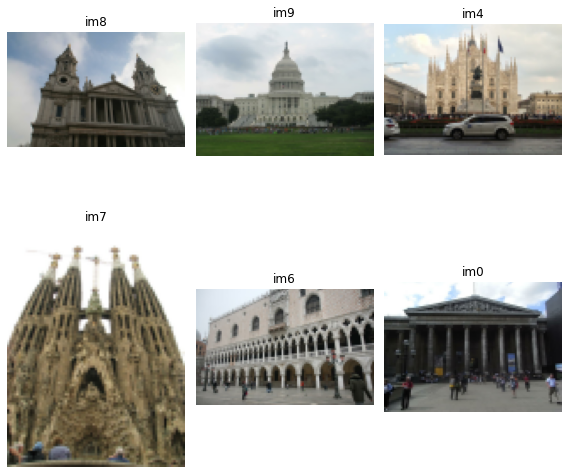

In [41]:
# Idx Item to Recommender
idx_ref = 1

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

### Search for items similar to the reference to recommend. Apparently it's working!

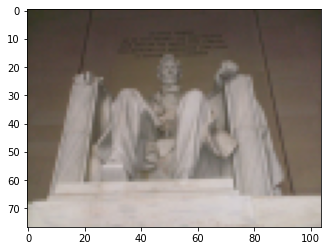

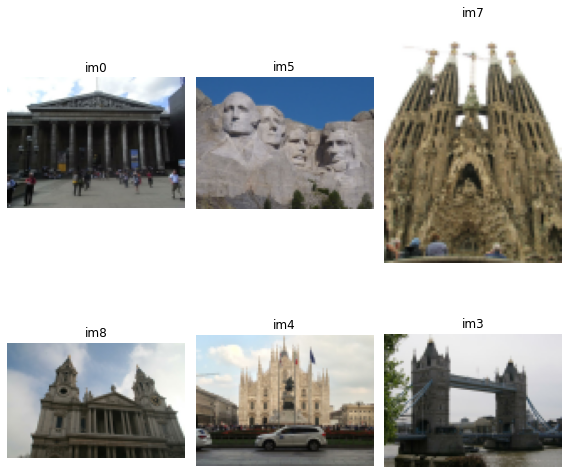

In [42]:
idx_ref = 2

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

### Visualization Latent Space of Contents

In [43]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [44]:
df.head()

,id,country,location,genre,season,image
0,british_museum,england,london,museum,all,british_museum.jpg
1,florence_cathedral_side,Italy,Florence,museum,all,florence_cathedral_side.jpg
2,lincoln_memorial_statue,United States,washington d.c.,museum,all,lincoln_memorial_statue.jpg
3,london_bridge,england,london,heritage,all,london_bridge.jpg
4,milan_cathedral,italy,milan,heritage,all,milan_cathedral.jpg


In [45]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 0.19814395904541016 seconds


In [46]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

In [47]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

ValueError: Could not interpret value `masterCategory` for parameter `hue`

<Figure size 1152x720 with 0 Axes>

In [48]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

ValueError: Could not interpret value `subCategory` for parameter `hue`

<Figure size 1152x720 with 0 Axes>